In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import random
import seaborn as sns

from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

# %matplotlib notebook
%matplotlib inline

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
import cached

from importlib import reload

reload(cached)

sim = cached.sim

In [3]:
def set_seed(i):
    random.seed(i)
    np.random.seed(random.getrandbits(32))

In [4]:
def draw(G, size="compute", layout=None):
    size = dict(G.nodes(data=size)).values()
    size = np.array(list(size)) * 1000
    size = np.interp(size, (size.min(), size.max()), (100, 2000))
    return_layout = False
    if not layout:
        layout = nx.spring_layout(G, weight="spring_weight")
        return_layout = True
    nx.draw(G, pos=layout, node_size=size)
    if return_layout:
        return layout


def print_(G):
    for l in nx.generate_graphml(G):
        print(l)

compute 7 [1, 2, 3, 4, 5, 6, 7]


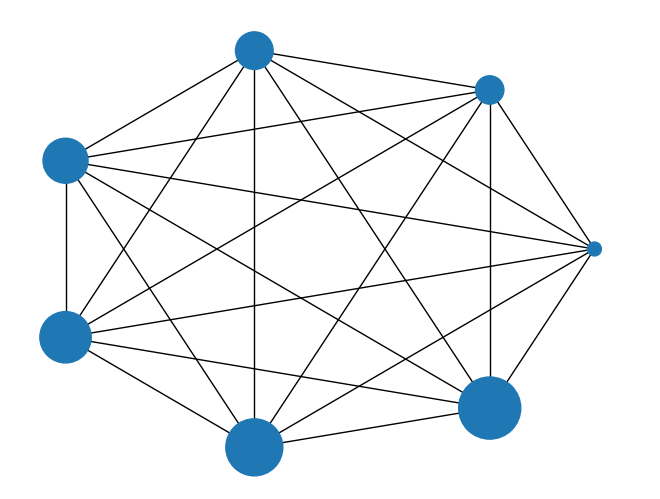

In [5]:
# Mining statistics for the last 7 days before Dec. 12 2022
# from https://www.blockchain.com/explorer/charts/pools
compute = [  # relative hash-rate # blocks mined / pool
    0.24817,  # 271 / Foundry USA
    0.20147,  # 220 / AntPool
    0.15110,  # 165 / F2Pool
    0.13736,  # 150 / Binance Pool
    0.10440,  # 114 / ViaBTC
    0.05311,  # 58  / Braiins Pool
    0.02473,  # 27  / Poolin
    0.01923,  # 21  / BTC.com
    0.01648,  # 18  / Luxor
    0.01465,  # 16  / Mara Pool
    0.00641,  # 7   / Ultimus
    0.00641,  # 7   / SBI Crypto
    0.00366,  # 4   / BTC M4
    0.00275,  # 3   / Titan
    # NaN    # 11  / Unknown
]
assert np.sum(compute) < 1
compute.append(1 - np.sum(compute))

compute = list(range(1, 8))

print("compute", len(compute), compute)

G = nx.complete_graph(len(compute))
G.graph["dissemination"] = "simple"

for i in range(len(compute)):
    G.nodes[i]["compute"] = compute[i]

for a, b in G.edges:
    # G.edges[a, b]["delay"] = f"uniform 0.5 1.5"
    G.edges[a, b]["delay"] = f"constant 1"

layout = nx.circular_layout(G)
draw(G, layout=layout)
# print_(G)

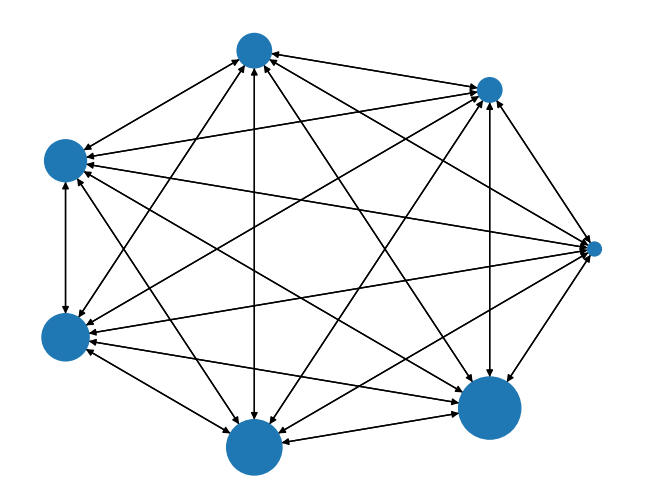

In [6]:
res = sim(G, activation_delay=1, activations=10000, protocol="nakamoto")
draw(res, size="reward", layout=layout)

In [7]:
# copied from https://stackoverflow.com/a/39513799
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad / np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [8]:
def subblock_selection(x):
    if x.k <= 32:
        return "heuristic"
    else:
        return "altruistic"


families = dict(
    nakamoto=lambda x: "nakamoto",
    bk=lambda x: f"bk-{x.k}-constant",
    bkll=lambda x: f"bkll-{x.k}-constant",
    tailstorm=lambda x: f"tailstorm-{x.k}-{x.scheme}-{subblock_selection(x)}",
    tailstormll=lambda x: f"tailstormll-{x.k}-{x.scheme}-{subblock_selection(x)}",
)

ks = dict(
    nakamoto=[1],
    bk=[2, 4, 8, 16, 32, 64, 128],
    bkll=[2, 4, 8, 16, 32, 64, 128],
    tailstorm=[2, 4, 8, 16, 32, 64, 128],
    tailstormll=[2, 4, 8, 16, 32, 64, 128],
)

schemes = dict(
    nakamoto=["constant"],
    bk=["constant"],
    bkll=["constant"],
    tailstorm=["constant", "discount"],
    tailstormll=["constant", "discount"],
)

block_intervals = [
    1,
    2,
    4,
    8,
    16,
    32,
    64,
    128,
]  # nakamoto/tailstorm/bk blocks, tailstorm summaries (multiples of expected message delay)


def rows():
    for f in families.keys():
        for s in schemes[f]:
            for k in ks[f]:
                for bi in block_intervals:
                    for i in range(100):
                        ad = bi / k  # activation delay
                        if ad >= 1:
                            yield pd.Series(
                                dict(
                                    family=f,
                                    k=k,
                                    scheme=s,
                                    protocol=f"{f}-{k}-{s}",
                                    block_interval=bi,
                                    activation_delay=ad,
                                    seed=i,
                                )
                            )


def read(G, field):
    return np.array([G.nodes[i][field] for i in range(len(compute))])


def measure(x):
    res = sim(
        G,
        activation_delay=x.activation_delay,
        activations=8192,
        protocol=families[x.family](x),
        seed=x.seed,
    )
    reward = read(res, "reward")
    activations = read(res, "activations")
    compute = read(res, "compute")
    relrew = reward / np.sum(reward)
    relrewn = reward / np.sum(reward) / compute
    efficiency0 = reward / compute
    efficiency1 = reward / activations
    weakest = np.argmin(compute)
    strongest = np.argmax(compute)
    return pd.Series(
        dict(
            reward=np.sum(reward),
            revenue_loss=1 - (np.sum(reward) / np.sum(activations)),
            weakest_reward=reward[weakest],
            weakest_relrew=relrew[weakest],
            weakest_relrewn=relrewn[weakest],
            weakest_efficiency0=efficiency0[weakest],
            weakest_efficiency1=efficiency1[weakest],
            strongest_reward=reward[strongest],
            strongest_relrew=relrew[strongest],
            strongest_relrewn=relrewn[strongest],
            strongest_efficiency0=efficiency0[strongest],
            strongest_efficiency1=efficiency1[strongest],
            diff_reward=reward[strongest] - reward[weakest],
            diff_relrew=relrew[strongest] - relrew[weakest],
            diff_relrewn=relrewn[strongest] - relrewn[weakest],
            diff_efficiency0=efficiency0[strongest] - efficiency0[weakest],
            diff_efficiency1=efficiency1[strongest] - efficiency1[weakest],
            gini_reward=gini(reward),
            gini_relrew=gini(relrew),
            gini_relrewn=gini(relrewn),
            gini_efficiency0=gini(efficiency0),
            gini_efficiency1=gini(efficiency1),
        )
    )


df = pd.DataFrame(rows())
df = df.sample(frac=1)  # shuffle to distribute load more evenly among the threads
# df = pd.concat([df, df.apply(measure, axis=1)], axis=1)
df = pd.concat([df, df.parallel_apply(measure, axis=1)], axis=1)
df = df.sort_index()
df

,family,k,scheme,protocol,block_interval,activation_delay,seed,reward,revenue_loss,weakest_reward,...,diff_reward,diff_relrew,diff_relrewn,diff_efficiency0,diff_efficiency1,gini_reward,gini_relrew,gini_relrewn,gini_efficiency0,gini_efficiency1
0,nakamoto,1,constant,nakamoto-1-constant,1,1.0,0,4869.0,0.405640,114.000000,...,1296.000000,0.266174,0.017956,87.428571,0.313995,0.347915,0.347915,0.096426,0.096426,0.100306
1,nakamoto,1,constant,nakamoto-1-constant,1,1.0,1,4869.0,0.405640,130.000000,...,1361.000000,0.279524,0.017047,83.000000,0.313790,0.360414,0.360414,0.094154,0.094154,0.097651
2,nakamoto,1,constant,nakamoto-1-constant,1,1.0,2,4879.0,0.404419,101.000000,...,1278.000000,0.261939,0.019676,96.000000,0.313687,0.353234,0.353234,0.112607,0.112607,0.108193
3,nakamoto,1,constant,nakamoto-1-constant,1,1.0,3,4933.0,0.397827,135.000000,...,1366.000000,0.276911,0.016101,79.428571,0.265102,0.363789,0.363789,0.102281,0.102281,0.100897
4,nakamoto,1,constant,nakamoto-1-constant,1,1.0,4,4827.0,0.410767,111.000000,...,1309.000000,0.271183,0.019030,91.857143,0.332597,0.366628,0.366628,0.115496,0.115496,0.119619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17595,tailstormll,128,discount,tailstormll-128-discount,128,1.0,95,4842.0,0.408936,169.835938,...,1056.992188,0.218297,0.001120,5.425223,0.007603,0.284837,0.284837,0.016175,0.016175,0.002738
17596,tailstormll,128,discount,tailstormll-128-discount,128,1.0,96,4869.0,0.405640,168.460938,...,1048.750000,0.215393,0.001114,5.426339,0.011166,0.284034,0.284034,0.016857,0.016857,0.004921
17597,tailstormll,128,discount,tailstormll-128-discount,128,1.0,97,4830.0,0.410400,164.734375,...,1068.734375,0.221270,0.002376,11.475446,0.006201,0.287847,0.287847,0.019095,0.019095,0.003200
17598,tailstormll,128,discount,tailstormll-128-discount,128,1.0,98,4817.0,0.411987,170.445312,...,1026.328125,0.213064,0.000108,0.522321,0.007529,0.286842,0.286842,0.009652,0.009652,0.002591


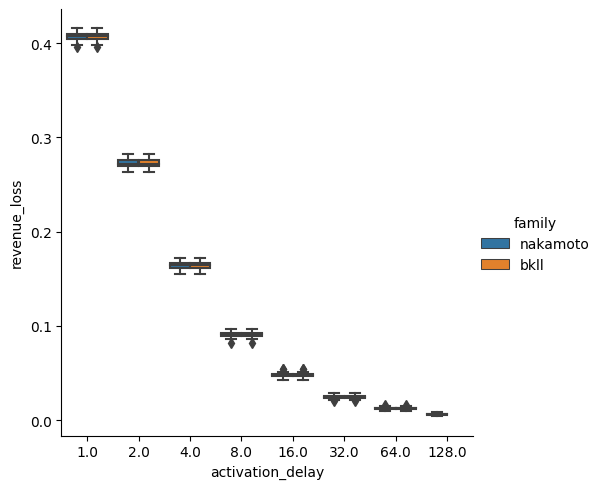

In [9]:
# check: nakamoto = bk_ll 2
ax = sns.catplot(
    data=df.query('family in ["nakamoto", "bkll"] and k in [1, 2]'),
    y="revenue_loss",
    x="activation_delay",
    hue="family",
    kind="box",
)

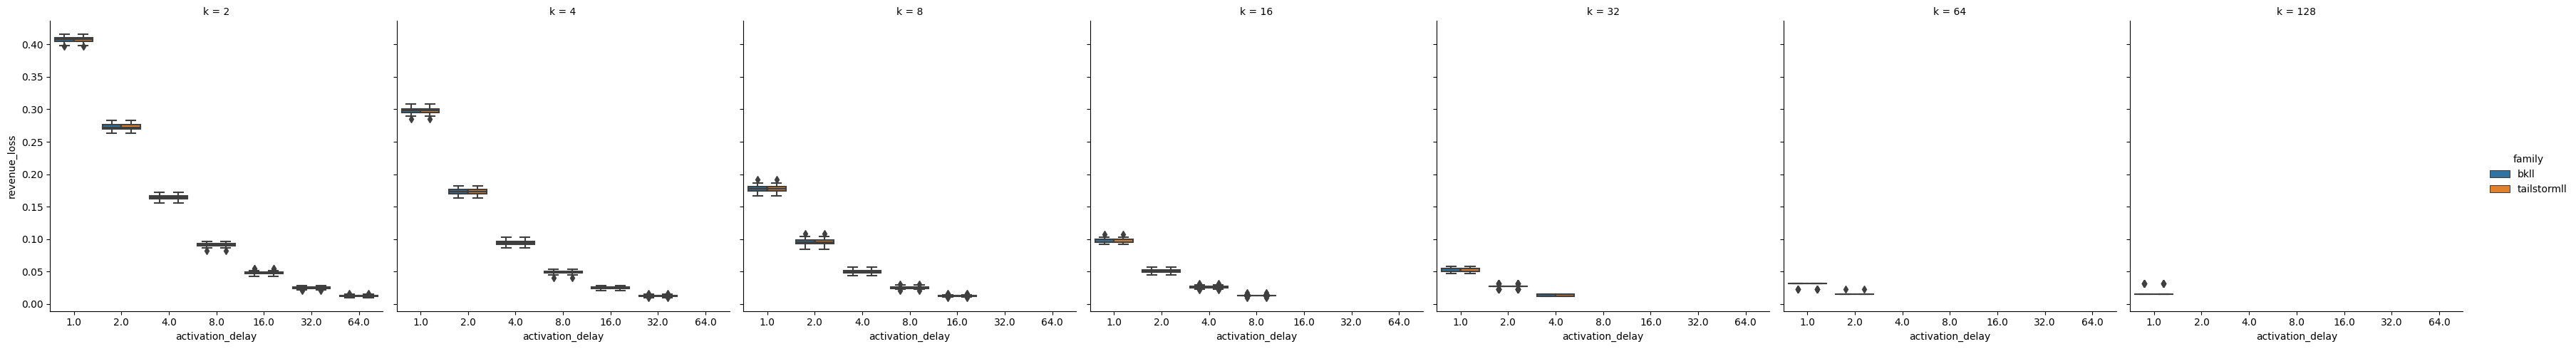

In [10]:
# check: bk_ll = tailstorm_ll constant
ax = sns.catplot(
    kind="box",
    data=df.query('family in ["bkll", "tailstormll"] and scheme == "constant"'),
    y="revenue_loss",
    x="activation_delay",
    hue="family",
    col="k",
)

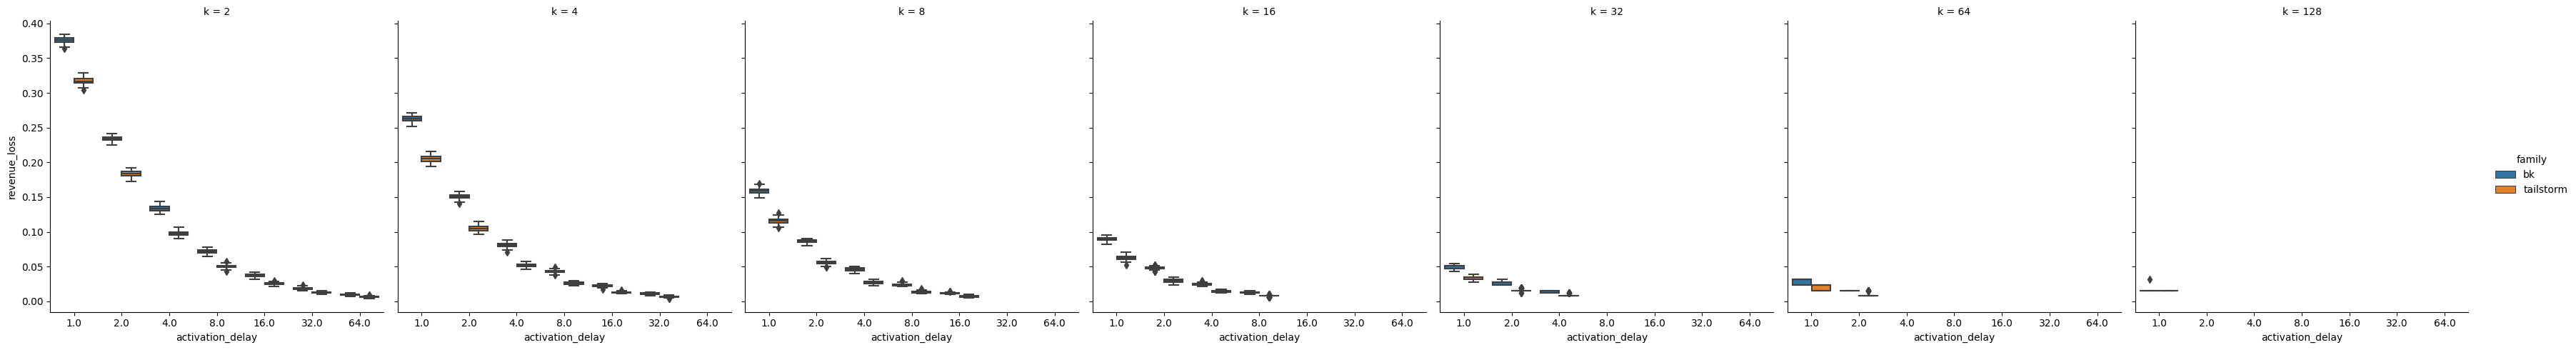

In [11]:
# check: bk != tailstorm constant
ax = sns.catplot(
    kind="box",
    data=df.query('family in ["bk", "tailstorm"] and scheme == "constant"'),
    y="revenue_loss",
    x="activation_delay",
    hue="family",
    col="k",
)

In [12]:
df = df.query('not (family == "tailstormll")')  # redundant with bkll
df = df.query('not (family == "bkll" and k == 2)')  # redundant with nakamoto

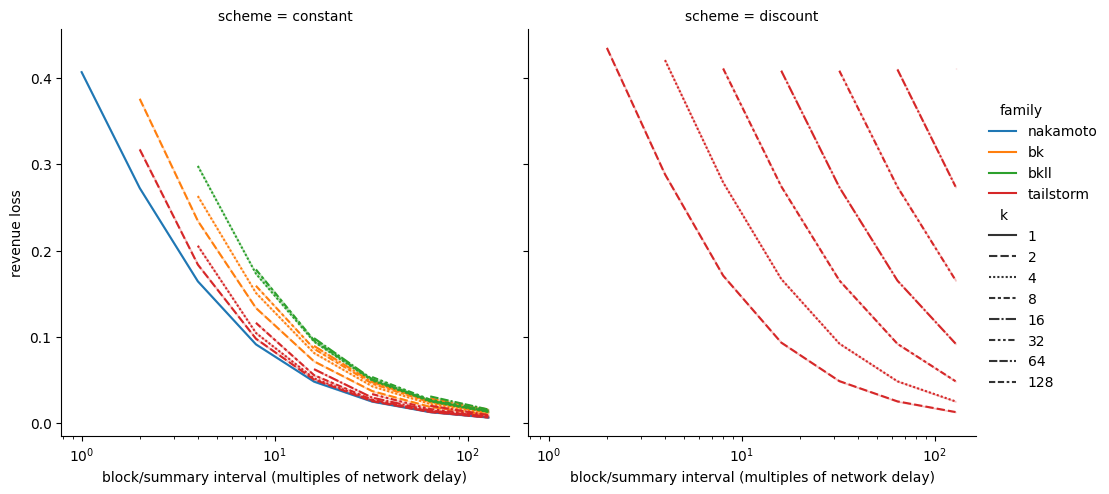

In [13]:
ax = sns.relplot(
    kind="line",
    data=df,
    hue="family",
    style="k",
    y="revenue_loss",
    x="block_interval",
    col="scheme",
)

ax.set(
    xscale="log",
    xlabel="block/summary interval (multiples of network delay)",
    ylabel="revenue loss",
)

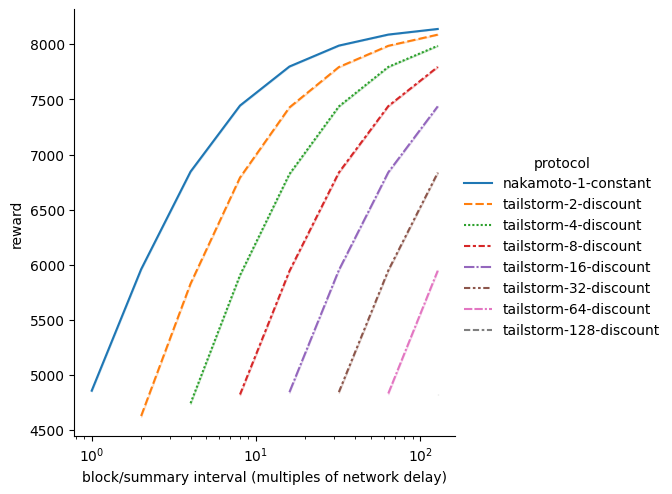

In [30]:
ax = sns.relplot(
    kind="line",
    data=df.query(
        "family == 'nakamoto' or (family == 'tailstorm' and scheme == 'discount')"
    ),
    hue="protocol",
    style="protocol",
    y="reward",
    x="block_interval",
)

ax.set(
    xscale="log",
    xlabel="block/summary interval (multiples of network delay)",
    ylabel="reward",
)

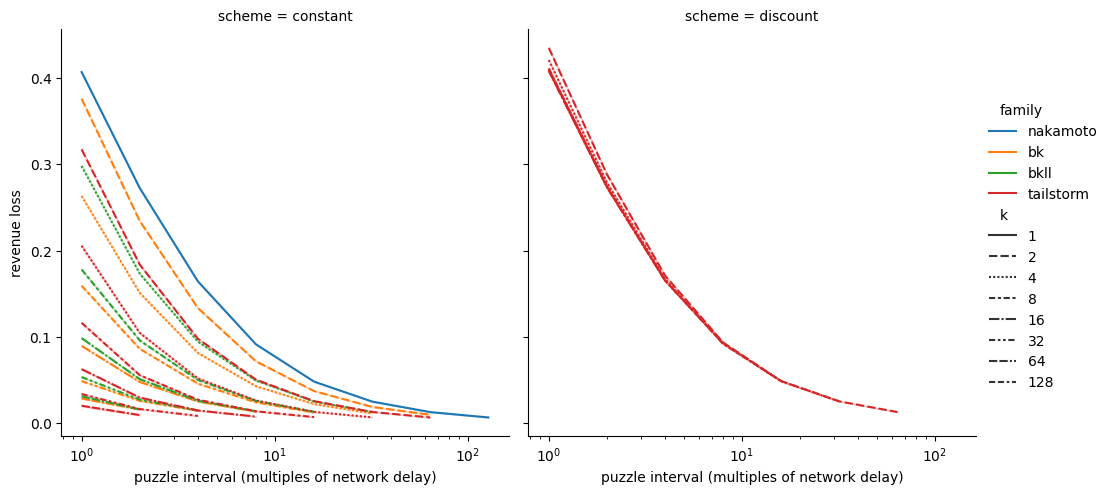

In [15]:
ax = sns.relplot(
    kind="line",
    data=df,
    hue="family",
    style="k",
    y="revenue_loss",
    x="activation_delay",
    col="scheme",
)

ax.set(
    xscale="log",
    xlabel="puzzle interval (multiples of network delay)",
    ylabel="revenue loss",
)

In [16]:
key = ["family", "k", "activation_delay", "block_interval"]
a = (
    df.query('scheme == "constant" and k in [1, 8]')
    .groupby(key)
    .agg(
        orphan_rate=("revenue_loss", np.mean),
        gini_constant=("gini_efficiency1", np.mean),
    )
)
b = (
    df.query('scheme != "constant" and k in [1, 8]')
    .groupby(key)
    .agg(
        revenue_loss=("revenue_loss", np.mean),
        gini_discount=("gini_efficiency1", np.mean),
    )
)
c = a.join(b)
for i, x in c.iterrows():
    if np.isnan(x.revenue_loss):
        c.loc[i]["revenue_loss"] = c.loc[i].orphan_rate
    if np.isnan(x.revenue_loss):
        c.loc[i]["revenue_loss"] = c.loc[i].orphan_rate
c.reset_index().sort_values(["block_interval", "family"])

,family,k,activation_delay,block_interval,orphan_rate,gini_constant,revenue_loss,gini_discount
10,nakamoto,1,1.0,1,0.406924,0.098168,0.406924,NaN
11,nakamoto,1,2.0,2,0.272461,0.047141,0.272461,NaN
12,nakamoto,1,4.0,4,0.164327,0.023427,0.164327,NaN
0,bk,8,1.0,8,0.159082,0.016692,0.159082,NaN
5,bkll,8,1.0,8,0.177979,0.022506,0.177979,NaN
13,nakamoto,1,8.0,8,0.091244,0.011901,0.091244,NaN
18,tailstorm,8,1.0,8,0.116162,0.012815,0.411132,0.024059
1,bk,8,2.0,16,0.086094,0.008191,0.086094,NaN
6,bkll,8,2.0,16,0.095801,0.011658,0.095801,NaN
14,nakamoto,1,16.0,16,0.048019,0.006251,0.048019,NaN


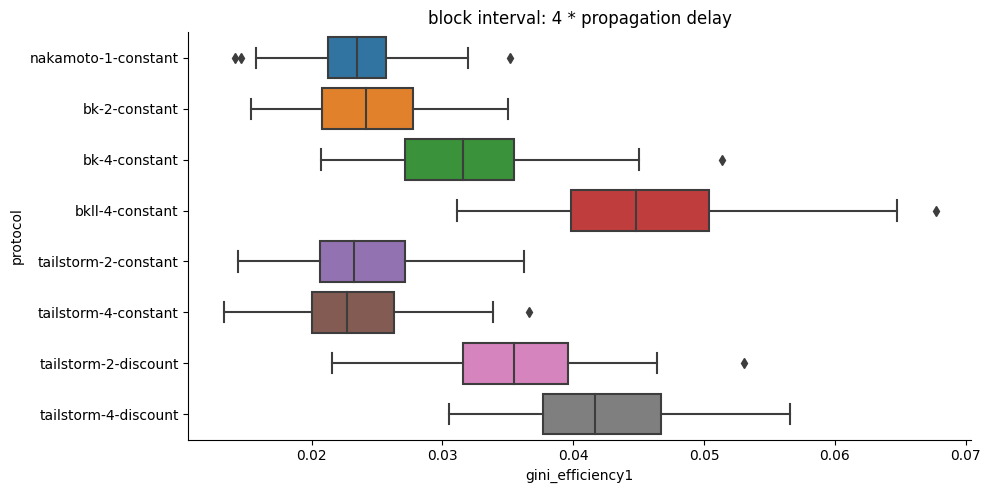

In [45]:
def bp_bi(metric, bi=32):
    plt = sns.catplot(
        data=df.query(f"block_interval == {bi}"),
        x=metric,
        y="protocol",
        kind="box",
        aspect=2,
        row="block_interval",
    )
    plt.set(title=f"block interval: {bi} * propagation delay")


def bp_ad(metric, ad=4):
    plt = sns.catplot(
        data=df.query(f"activation_delay == {ad}"),
        x=metric,
        y="protocol",
        kind="box",
        aspect=2,
    )
    plt.set(title=f"activation delay: {ad} * propagation delay")


bp_bi("gini_efficiency1", bi=4)

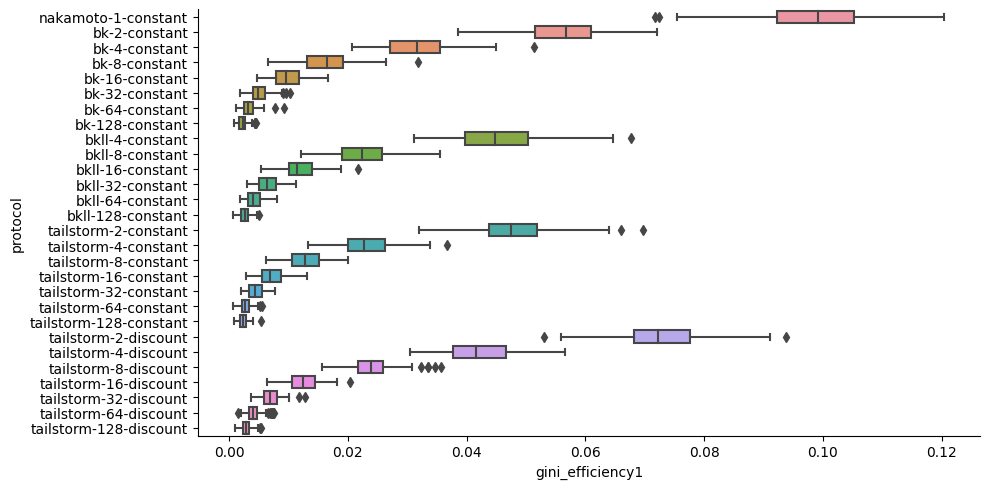

In [21]:
bp_ad("gini_efficiency1", ad=)

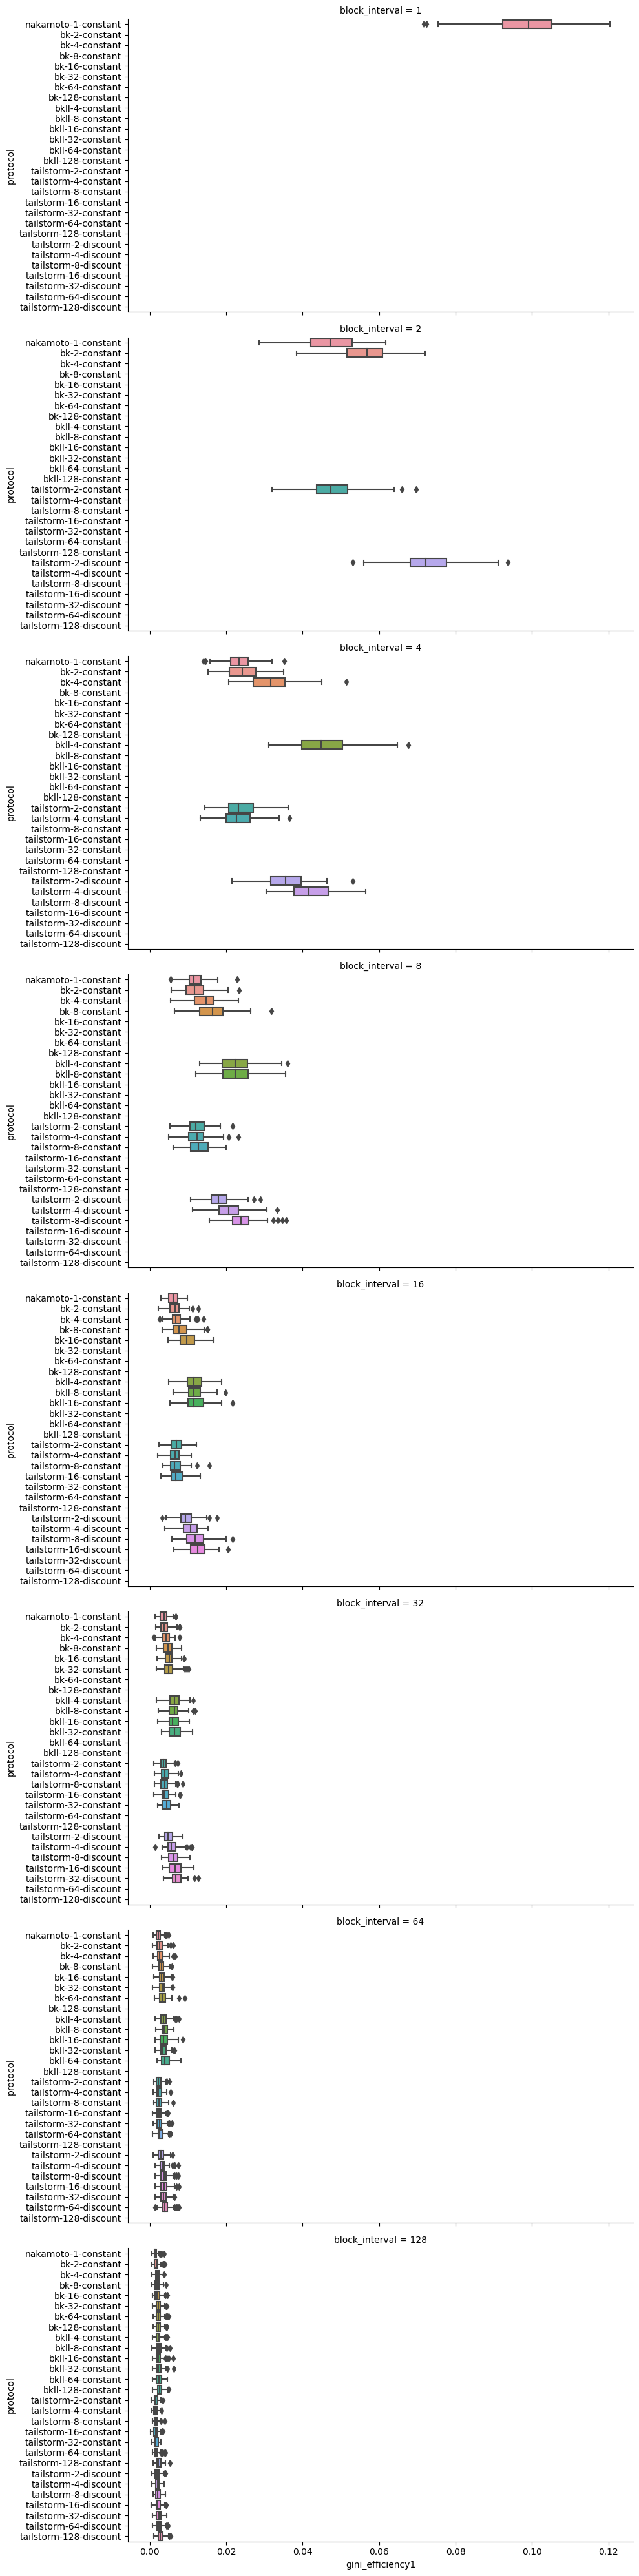

In [47]:
plt = sns.catplot(
    data=df,
    x="gini_efficiency1",
    y="protocol",
    kind="box",
    aspect=2,
    row="block_interval",
)

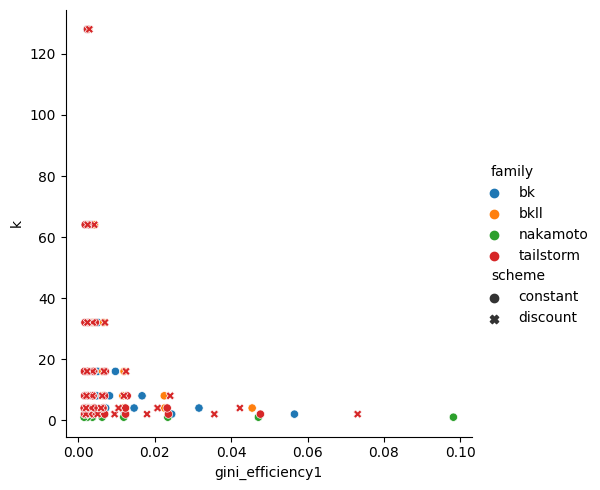

In [20]:
scenario = ["family", "k", "scheme", "protocol", "activation_delay", "block_interval"]
d = (
    df.groupby(scenario)
    .agg(gini_efficiency1=("gini_efficiency1", np.mean))
    .reset_index()
)
sns.relplot(
    data=d,
    x="gini_efficiency1",
    y="k",
    hue="family",
    style="scheme",
)